# DX 704 Week 3 Project

This week's project will give you practice with optimizing choices for bandit algorithms.
You will be given access to the bandit problem via a blackbox object, and you will investigate the bandit rewards to pick a suitable algorithm.

The full project description, a template notebook and supporting code are available on GitHub: [Project 3 Materials](https://github.com/bu-cds-dx704/dx704-project-03).


## Example Code

You may find it helpful to refer to these GitHub repositories of Jupyter notebooks for example code.

* https://github.com/bu-cds-omds/dx601-examples
* https://github.com/bu-cds-omds/dx602-examples
* https://github.com/bu-cds-omds/dx603-examples
* https://github.com/bu-cds-omds/dx704-examples

Any calculations demonstrated in code examples or videos may be found in these notebooks, and you are allowed to copy this example code in your homework answers.

## Part 1: Pick a Bandit Algorithm

Experiment with the multi-armed bandit interface using seed 0 to learn about the distribution of rewards and decide what kind of bandit algorithm will be appropriate.
A histogram will likely be helpful.

In [1]:
# DO NOT CHANGE

import numpy as np

class BanditProblem(object):
    def __init__(self, seed):
        self.seed = seed
        self.rng = np.random.default_rng(seed)

        self.num_arms = 3
        self.ns = self.rng.integers(low=1, high=10, size=self.num_arms)
        self.ps = self.rng.uniform(low=0.2, high=0.4, size=self.num_arms)

    def get_num_arms(self):
        return self.num_arms

    def get_reward(self, arm):
        if arm < 0 or arm >= self.num_arms:
            raise ValueError("Invalid arm")

        x = self.rng.uniform()
        x *= self.rng.binomial(self.ns[arm], self.ps[arm])

        return x


In [2]:
bandit0 = BanditProblem(0)

In [3]:
bandit0.get_num_arms()

3

In [4]:
bandit0.get_reward(arm=0)

1.8255111545554434

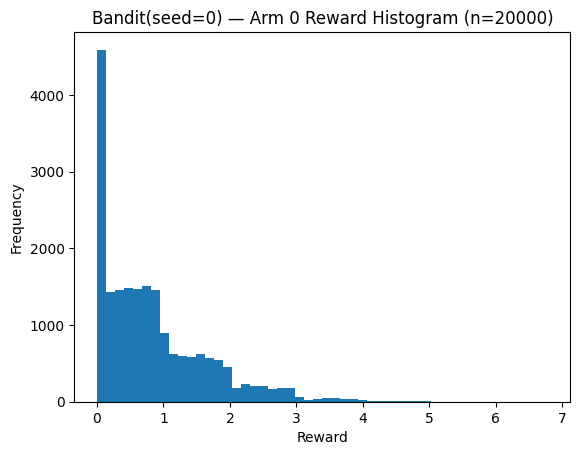

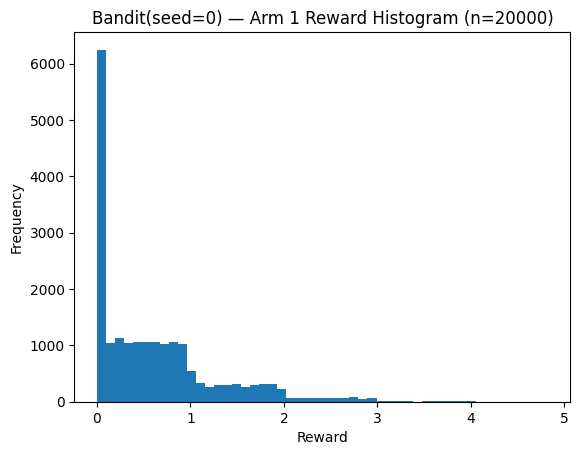

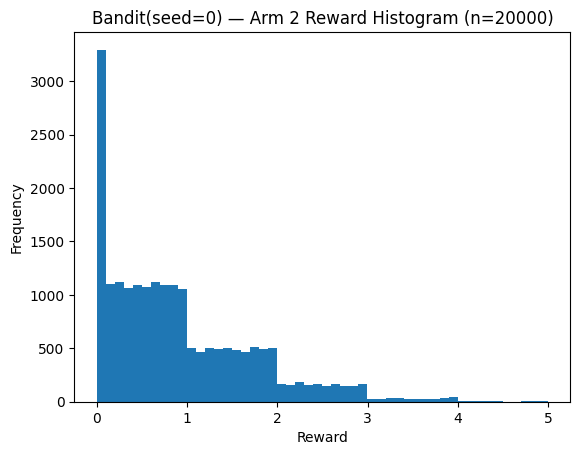

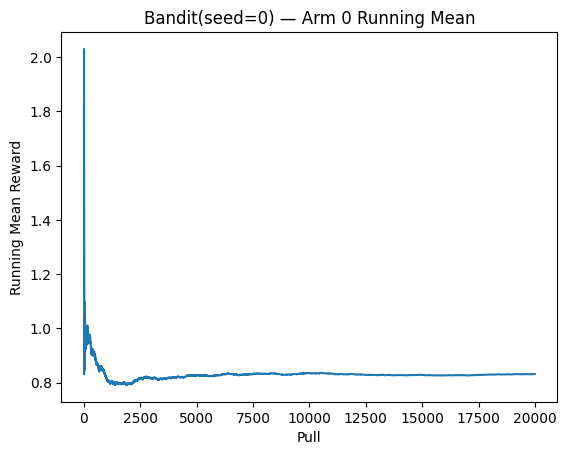

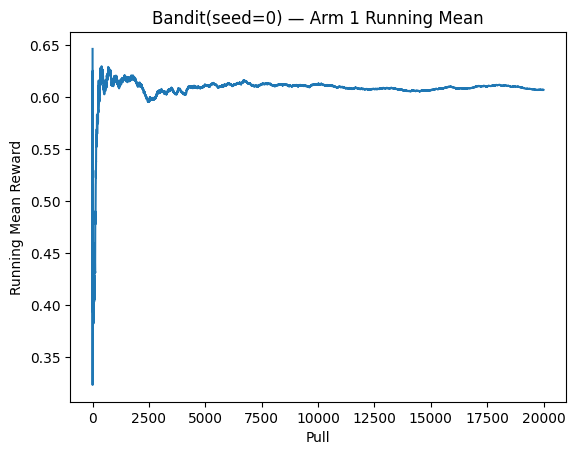

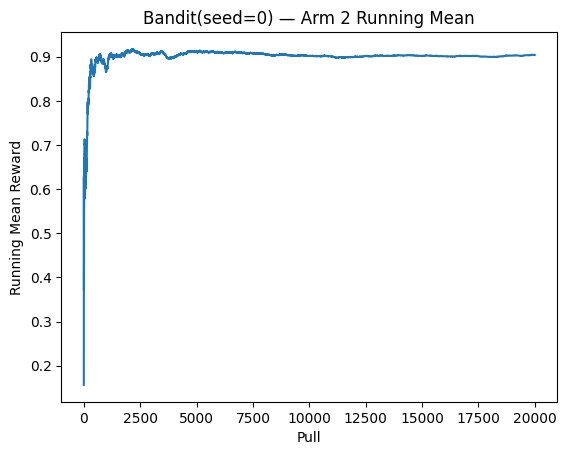

,arm,mean,std,min,p25,median,p75,max,nonzero_rate
0,0,0.8319,0.8188,0.0,0.1739,0.6417,1.2386,6.7825,0.8444
1,1,0.6068,0.6742,0.0,0.0000,0.4339,0.8924,4.8232,0.7382
2,2,0.9041,0.8199,0.0,0.2542,0.7104,1.3851,4.9981,0.8916


In [5]:
# YOUR CHANGES HERE

# Explore reward distributions
import matplotlib.pyplot as plt
import pandas as pd

class BanditProblem(object):
    def __init__(self, seed):
        self.seed = seed
        self.rng = np.random.default_rng(seed)

        self.num_arms = 3
        self.ns = self.rng.integers(low=1, high=10, size=self.num_arms)
        self.ps = self.rng.uniform(low=0.2, high=0.4, size=self.num_arms)

    def get_num_arms(self):
        return self.num_arms

    def get_reward(self, arm):
        if arm < 0 or arm >= self.num_arms:
            raise ValueError("Invalid arm")

        x = self.rng.uniform()
        x *= self.rng.binomial(self.ns[arm], self.ps[arm])

        return x

# Instantiate with seed 0
bandit0 = BanditProblem(0)

# Sample rewards
n_samples = 20000
rewards = {arm: [] for arm in range(bandit0.get_num_arms())}

for arm in range(bandit0.get_num_arms()):
    for _ in range(n_samples):
        rewards[arm].append(bandit0.get_reward(arm))

# Compute summary stats
stats_rows = []
for arm in range(bandit0.get_num_arms()):
    arr = np.array(rewards[arm], dtype=float)
    stats_rows.append({
        "arm": arm,
        "mean": float(arr.mean()),
        "std": float(arr.std(ddof=1)),
        "min": float(arr.min()),
        "p25": float(np.percentile(arr, 25)),
        "median": float(np.median(arr)),
        "p75": float(np.percentile(arr, 75)),
        "max": float(arr.max()),
        "nonzero_rate": float((arr > 0).mean())
    })

stats_df = pd.DataFrame(stats_rows).round(4)
stats_df

# Plot histograms for each arm (one chart per plot, per tool rules)
bins = 50
for arm in range(bandit0.get_num_arms()):
    plt.figure()
    plt.hist(rewards[arm], bins=bins)
    plt.title(f"Bandit(seed=0) — Arm {arm} Reward Histogram (n={n_samples})")
    plt.xlabel("Reward")
    plt.ylabel("Frequency")
    plt.show()

# Additionally, show running mean per arm to visualize convergence
for arm in range(bandit0.get_num_arms()):
    arr = np.array(rewards[arm], dtype=float)
    running_mean = np.cumsum(arr) / (np.arange(len(arr)) + 1)
    plt.figure()
    plt.plot(running_mean)
    plt.title(f"Bandit(seed=0) — Arm {arm} Running Mean")
    plt.xlabel("Pull")
    plt.ylabel("Running Mean Reward")
    plt.show()

stats_df

Based on your investigation, pick an appropriate bandit algorithm to implement from the algorithms covered this week.
Write a file "algorithm-choice.txt" that states your choice and gives a few sentences justifying your choice and rejecting the alternatives.
Keep your explanation concise; overly verbose responses will be penalized.

In [6]:
text = """My choice is UCB (Upper Confidence Bound)

Justification: Rewards are bounded, right-skewed with unequal variances and many zeros. 
UCB deals with those factors by being variance aware and simple with continuous bounded rewards. 
It also avoids the modeling assumptions required for Thompson Sampling and the potentially wasteful
overhead of ε-greedy

"""

# Write to a text file
with open("algorithm-choice.txt", "w") as f:
    f.write(text)

print("File 'algorithm-choice.txt' written successfully.")

File 'algorithm-choice.txt' written successfully.


## Part 2: Implement Bandit

Based on your decision, implement an appropriate bandit algorithm and pick 1000 actions using seed 2025002.

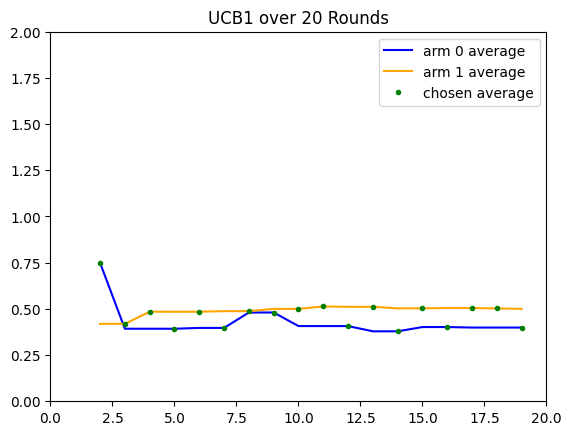

In [25]:
# YOUR CHANGES HERE

import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import scipy.stats
from IPython.display import HTML

np.random.seed(2025002)

# rewards will be drawn uniformly randomly from these ranges

K = 2
reward_true_ranges = [[0.0, 0.8], [0.4, 0.6]]
T_max = 1000

arm_counts = [0 for _ in range(K)]
arm_totals = [0 for _ in range(K)]
arm_averages = [None for _ in range(K)]
chosen_averages = []

rewards = [] 
actions = []

def sample_reward(j):
    r = np.random.uniform(reward_true_ranges[j][0], reward_true_ranges[j][1])

    chosen_averages.append(arm_averages[j])

    arm_counts[j] += 1
    arm_totals[j] += r
    arm_averages[j] = arm_totals[j] / arm_counts[j]
    rewards.append(r)
    actions.append(j)
    return r

# sample each arm once
for t in range(K):
    sample_reward(t)

arm_averages_history = []
ucb1_bounds_history = []

# sample using UCB1
for t in range(K, T_max):
    # calculate the UCB1 bound for each arm
    ucb1_bounds = [arm_averages[j] + math.sqrt(2 * math.log(t) / arm_counts[j]) for j in range(K)]

    arm_averages_history.append(arm_averages.copy())
    ucb1_bounds_history.append(ucb1_bounds)

    # pick and sample the arm with the highest bound
    j = np.argmax(ucb1_bounds)
    sample_reward(j)

arm_averages_history = np.array(arm_averages_history)
ucb1_bounds_history = np.array(ucb1_bounds_history)
chosen_averages = np.array(chosen_averages)

def plot(T, bounds=True):
    average0 = plt.plot(range(K, T), arm_averages_history[:T-K,0], label="arm 0 average", color="blue")
    if bounds:
        ucb1_bound0 = plt.plot(range(K, T), ucb1_bounds_history[:T-K,0], label="arm 0 bound", color="blue", linestyle="--")
    average1 = plt.plot(range(K, T), arm_averages_history[:T-K,1], label="arm 1 average", color="orange")
    if bounds:
        ucb1_bound1 = plt.plot(range(K, T), ucb1_bounds_history[:T-K,1], label="arm 1 bound", color="orange", linestyle="--")

    if T <= 100:
        chosen_average = plt.plot(range(K, T), chosen_averages[K:T], label="chosen average", color="green", linestyle="none", marker=".")

    plt.legend()
    plt.title(f"UCB1 over {T} Rounds")
    plt.xlim(0, T)
    plt.ylim(0, 2)

    plt.show()

plot(20, bounds=False)

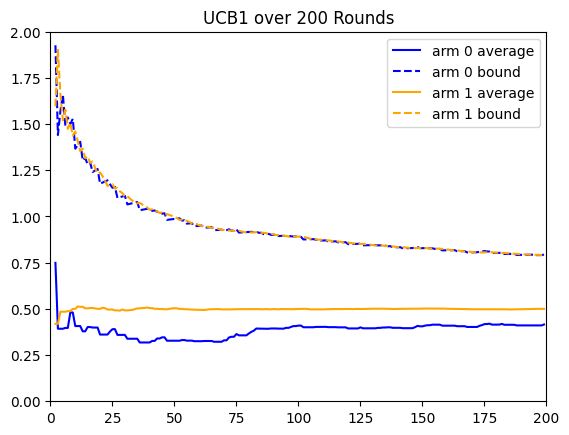

In [26]:
plot(200)

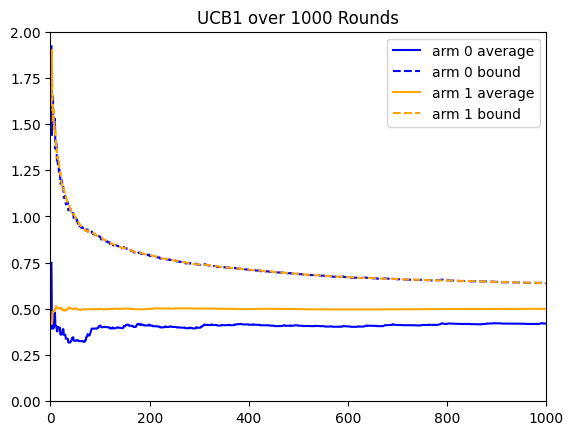

In [27]:
plot(1000)

Write a file "history.tsv" with columns action and reward in the order that the actions were taken.

In [28]:
# YOUR CHANGES HERE
history = pd.DataFrame({
    "action": actions,
    "reward": rewards
})

# write to TSV
history.to_csv("history.tsv", sep="\t", index=False)

Submit "history.tsv" in Gradescope.

## Part 3: Action Statistics

Based on the data from part 2, estimate the expected reward for each arm and write a file "actions.tsv" with the columns action, min_reward, mean_reward, max_reward.

In [29]:
# YOUR CHANGES HERE

history = pd.DataFrame({"action": actions, "reward": rewards})

summary = history.groupby("action")["reward"].agg(
    min_reward="min",
    mean_reward="mean",
    max_reward="max"
).reset_index()


# write to TSV
summary.to_csv("actions.tsv", sep="\t", index=False)

Submit "actions.tsv" in Gradescope.

## Part 4: Regret Estimates

Calculate the expected regret taking 1000 actions with the following strategies.

* uniform: Pick an arm uniformly at random.
* just-i: Always pick arm $i$. Do this for $i=0$ to $K-1$ where $K$ is the number of arms.
* actual: This should match your output in part 2.

In [30]:
# YOUR CHANGES HERE
#  Uniform
mus = np.array([(lo + hi) / 2 for (lo, hi) in reward_true_ranges])  # e.g., [0.4, 0.5]
mu_star = float(np.max(mus))
K = len(mus)
T = 1000

regret_uniform = T * (mu_star - float(np.mean(mus)))


In [31]:
# just-i
regret_just = {i: T * (mu_star - mus[i]) for i in range(K)}

In [32]:
# actual
assert len(actions) == T, f"Expected {T} actions, got {len(actions)}"
regret_actual = float(np.sum(mu_star - mus[np.array(actions, dtype=int)]))

print(f"Expected regrets over {T} actions:")
print(f"  uniform : {regret_uniform:.4f}")
for i in range(K):
    print(f"  just-{i} : {regret_just[i]:.4f}")
print(f"  actual  : {regret_actual:.4f}")

Expected regrets over 1000 actions:
  uniform : 50.0000
  just-0 : 100.0000
  just-1 : 0.0000
  actual  : 29.0000


Write your results to a file "strategies.tsv" with the columns strategy and regret.

In [33]:
# YOUR CHANGES HERE
rows = []
rows.append({"strategy": "uniform", "regret": regret_uniform})
for i in range(K):
    rows.append({"strategy": f"just-{i}", "regret": regret_just[i]})
rows.append({"strategy": "actual", "regret": regret_actual})

strategies = pd.DataFrame(rows)
strategies["regret"] = strategies["regret"].round(4)

# write to TSV
strategies.to_csv("strategies.tsv", sep="\t", index=False)

print(strategies)

  strategy  regret
0  uniform    50.0
1   just-0   100.0
2   just-1     0.0
3   actual    29.0


Submit "strategies.tsv" in Gradescope.

## Part 5: Acknowledgments

Make a file "acknowledgments.txt" documenting any outside sources or help on this project.
If you discussed this assignment with anyone, please acknowledge them here.
If you used any libraries not mentioned in this module's content, please list them with a brief explanation what you used them for.
If you used any generative AI tools, please add links to your transcripts below, and any other information that you feel is necessary to comply with the generative AI policy.
If no acknowledgements are appropriate, just write none in the file.


Submit "acknowledgments.txt" in Gradescope.

## Part 6: Code

Please submit a Jupyter notebook that can reproduce all your calculations and recreate the previously submitted files.

Submit "project.ipynb" in Gradescope.